In [1]:
from tensorflow import keras
import pandas as pd
from keras import Sequential
from keras.layers import LSTM,Dense,Dropout, Embedding, Conv1D, MaxPooling1D, Flatten
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # use id from $ nvidia-smi


%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_imdb(path):
    from bs4 import BeautifulSoup
    import re, json
    import pandas as pd
    
    def preprocess(text):
        text = BeautifulSoup(text.lower(), "html5lib").text #removed html tags
        text = re.sub(r"[\W]+", " ", text)
        return text
    
    with open(path, "r", encoding="utf8") as f:
        comments = pd.DataFrame.from_dict([json.loads(l) for l in f])
        comments["content"] = comments["content"].apply(preprocess)
        return comments
        
comments = load_imdb("/data/imdb-comments.json")
comments.head()

,content,label,name,sentiment
0,i went and saw this movie last night after bei...,test,0_10.txt,pos
1,actor turned director bill paxton follows up h...,test,10000_7.txt,pos
2,as a recreational golfer with some knowledge o...,test,10001_9.txt,pos
3,i saw this film in a sneak preview and it is d...,test,10002_8.txt,pos
4,bill paxton has taken the true story of the 19...,test,10003_8.txt,pos


In [3]:
comments.sample(10)

,content,label,name,sentiment
25283,this movie is the first of the six infamous gu...,train,10255_9.txt,pos
19190,the ruins is to turistas as deep impact was to...,test,4772_1.txt,neg
48651,what a shame it is when a potentially captivat...,train,8788_3.txt,neg
14310,i got this movie for fifty cents at a going ou...,test,1162_1.txt,neg
19089,andy milligan the independent movie maker from...,test,4681_1.txt,neg
2714,from the golden period of british films this h...,test,12443_10.txt,pos
16736,steven seagal played in many action movies mos...,test,2563_1.txt,neg
12741,alert this review contains major spoilers do n...,test,10217_4.txt,neg
35219,spoilers alerthomeward bound the incredible jo...,train,7949_10.txt,pos
26776,it really is a shame that films like this neve...,train,1159_10.txt,pos


In [6]:
y = np.where(comments.sentiment == "pos", 1, 0)
is_training = comments.label == "train"

In [7]:
maxlen = 1250

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(comments.content)
doc_terms = tokenizer.texts_to_sequences(comments.content)
len(doc_terms)

50000

In [9]:
comments.content[0]

'i went and saw this movie last night after being coaxed to by a few friends of mine i ll admit that i was reluctant to see it because from what i knew of ashton kutcher he was only able to do comedy i was wrong kutcher played the character of jake fischer very well and kevin costner played ben randall with such professionalism the sign of a good movie is that it can toy with our emotions this one did exactly that the entire theater which was sold out was overcome by laughter during the first half of the movie and were moved to tears during the second half while exiting the theater i not only saw many women in tears but many full grown men as well trying desperately not to let anyone see them crying this movie was great and i suggest that you go see it before you judge '

In [10]:
print(doc_terms[0])

[9, 416, 2, 210, 10, 15, 238, 311, 100, 109, 28203, 5, 33, 3, 173, 352, 4, 1758, 9, 232, 975, 11, 9, 13, 5735, 5, 65, 7, 84, 37, 47, 9, 672, 4, 9942, 9315, 24, 13, 62, 477, 5, 78, 201, 9, 13, 356, 9315, 254, 1, 104, 4, 3373, 15901, 53, 69, 2, 1621, 7132, 254, 1155, 8399, 17, 139, 11306, 1, 2016, 4, 3, 49, 15, 6, 11, 7, 50, 2970, 17, 258, 1334, 10, 28, 117, 619, 11, 1, 442, 764, 61, 13, 2986, 43, 13, 3232, 33, 2142, 303, 1, 88, 304, 4, 1, 15, 2, 71, 1649, 5, 1716, 303, 1, 338, 304, 136, 11778, 1, 764, 9, 23, 62, 210, 107, 362, 8, 1716, 18, 107, 364, 2061, 339, 14, 69, 264, 2816, 23, 5, 276, 246, 65, 92, 2488, 10, 15, 13, 80, 2, 9, 1466, 11, 20, 141, 65, 7, 161, 20, 1671]


In [12]:
tokenizer.word_docs["i"]

39797

In [16]:
str(tokenizer.word_docs.items())[:500]

"dict_items([('coaxed', 9), ('let', 4066), ('but', 35787), ('in', 44006), ('ashton', 49), ('the', 49560), ('character', 9551), ('with', 34776), ('able', 2361), ('grown', 464), ('it', 44511), ('good', 19000), ('not', 29780), ('emotions', 749), ('only', 16467), ('first', 12611), ('judge', 516), ('our', 3688), ('before', 7146), ('reluctant', 133), ('that', 40473), ('by', 23344), ('he', 20422), ('did', 9445), ('see', 16263), ('women', 2531), ('well', 15001), ('during', 3682), ('movie', 30562), ('a', "

In [24]:
n_dim = len(tokenizer.word_docs.keys()) # Dimension of doc term matrix
n_dim

103890

In [13]:
words_by_index = dict([(i, word) for word, i in tokenizer.word_index.items()])

In [14]:
print([words_by_index[t] for t in doc_terms[0]])

['i', 'went', 'and', 'saw', 'this', 'movie', 'last', 'night', 'after', 'being', 'coaxed', 'to', 'by', 'a', 'few', 'friends', 'of', 'mine', 'i', 'll', 'admit', 'that', 'i', 'was', 'reluctant', 'to', 'see', 'it', 'because', 'from', 'what', 'i', 'knew', 'of', 'ashton', 'kutcher', 'he', 'was', 'only', 'able', 'to', 'do', 'comedy', 'i', 'was', 'wrong', 'kutcher', 'played', 'the', 'character', 'of', 'jake', 'fischer', 'very', 'well', 'and', 'kevin', 'costner', 'played', 'ben', 'randall', 'with', 'such', 'professionalism', 'the', 'sign', 'of', 'a', 'good', 'movie', 'is', 'that', 'it', 'can', 'toy', 'with', 'our', 'emotions', 'this', 'one', 'did', 'exactly', 'that', 'the', 'entire', 'theater', 'which', 'was', 'sold', 'out', 'was', 'overcome', 'by', 'laughter', 'during', 'the', 'first', 'half', 'of', 'the', 'movie', 'and', 'were', 'moved', 'to', 'tears', 'during', 'the', 'second', 'half', 'while', 'exiting', 'the', 'theater', 'i', 'not', 'only', 'saw', 'many', 'women', 'in', 'tears', 'but', 'ma

In [15]:
words_by_index[9]

'i'

In [17]:
vocab_size = len(tokenizer.word_index)
vocab_size

103890

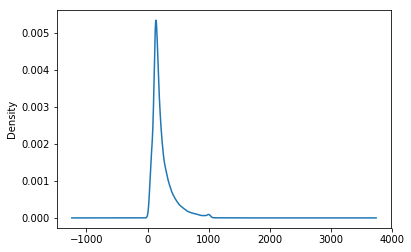

In [20]:
pd.Series([len(r) for r in doc_terms]).plot.kde()

In [21]:
doc_terms_padded = pad_sequences(doc_terms, maxlen=maxlen)
doc_terms_padded[0]

array([   0,    0,    0, ...,  161,   20, 1671], dtype=int32)

In [22]:
x_train = doc_terms_padded[is_training]
y_train = y[is_training]
x_test = doc_terms_padded[~is_training]
y_test = y[~is_training]

In [25]:
tf.set_random_seed(1)
np.random.seed(1)

model = Sequential()
model.add(Embedding(input_dim = n_dim + 1, output_dim = 10, input_length=maxlen))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, activation='elu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(128, 3, activation='elu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(400, activation='elu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, epochs=100)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1250, 10)          1038910   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1250, 10)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1246, 64)          3264      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 311, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 309, 128)          24704     
_________________________________________________________________
max_pooling1d_2 (MaxP

KeyboardInterrupt: 